# Required Dependencies

In [17]:
import numpy as np
from pgmpy.models import MarkovNetwork
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.inference import BeliefPropagation
import itertools

import networkx as nx
import matplotlib.pyplot as plt

# Problem 1

We consider a small Markov Random Field describing a distribution of 5 binary (-1, 1 values)variables: A1, A2, A3, A4, A5. The relations of conditional independence are as follows: A1 is connected with A2 and A3. A2 is conected with A4 and A5 , A3 is connected to A4, A4 is connected with A5

The local functions coresponding to the clique is as follows:


phi(Ai1, Ai2, ..., Ain) = e ** {i1Ai1 + i2Ai2 + ... + inAin}

## Sub Problem a

using pgmpy, visualize the graph of the Markov Network. And determine the clique of the model

**Solution**

Building and visualizing the Markov Network

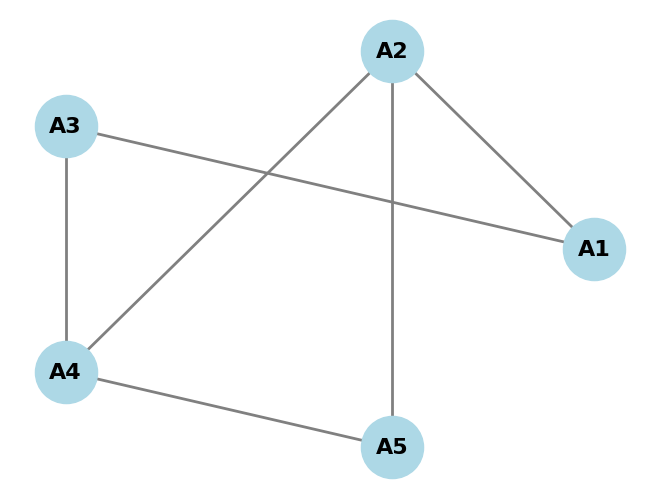

In [9]:
model = MarkovNetwork()

model.add_nodes_from(['A1', 'A2', 'A3', 'A4', 'A5'])

model.add_edges_from([
    ('A1', 'A2'),
    ('A1', 'A3'),
    ('A2', 'A4'),
    ('A2', 'A5'),
    ('A3', 'A4'),
    ('A4', 'A5')
])

pos = nx.circular_layout(model)
nx.draw(model, pos, with_labels=True, node_color='lightblue',
        node_size=2000, font_size=16, font_weight='bold',
        edge_color='gray', width=2, arrowsize=20)



Based of this graph, the clique here is the subgraph consisting of `G={[A2, A4, A5], [(A2, A4), (A4, A5), (A5, A2)]}`

Of course, more cliques can be found, buit the above is the maximum one

Finding all cliques in code

In [10]:
cliques = list(nx.find_cliques(model))

for i, clique in enumerate(cliques, 1):
    print(f"Clique {i}: {clique}")


Clique 1: ['A4', 'A5', 'A2']
Clique 2: ['A4', 'A3']
Clique 3: ['A1', 'A2']
Clique 4: ['A1', 'A3']


## Sub Problem b
Determine the joint distribution of the five variables and infer the states of maximum probabilities for them

**Solution**

Defining the potential function for each clique

In [27]:
def create_potential(vars, indicies):
    card = [2] * len(vars)
    values = []

    for combination in itertools.product([-1, 1], repeat=len(vars)):
        exponent = sum(idx*val for idx, val in zip(indicies, combination))
        values.append(np.exp(exponent))

    values = np.array(values).reshape(card)
    return DiscreteFactor(vars, card, values)

In [33]:

phi_A1_A2 = create_potential(['A1', 'A2'], [1, 2])
phi_A1_A3 = create_potential(['A1', 'A3'], [1, 3])
phi_A2_A4 = create_potential(['A2', 'A4'], [2, 4])
phi_A2_A5 = create_potential(['A2', 'A5'], [2, 5])
phi_A3_A4 = create_potential(['A3', 'A4'], [3, 4])
phi_A4_A5 = create_potential(['A4', 'A5'], [4, 5])

model.add_factors(phi_A1_A2, phi_A1_A3, phi_A2_A4, phi_A2_A5, phi_A3_A4, phi_A4_A5)

print("This model is valid: ", model.check_model())

# inference with belief propagation

bp = BeliefPropagation(model)

# MAP finding

map_result = bp.map_query(variables=['A1', 'A2', 'A3', 'A4', 'A5'])
for var, value in map_result.items():
    actual_value = -1 if value == 0 else 1
    print(f"{var}: {actual_value}")

# Computing marginal probabilities

for var in ['A1', 'A2', 'A3', 'A4', 'A5']:
    marginal = bp.query(variables=[var])
    print(f"{var}: {marginal}")


# Computing the joint distribution

joint = bp.query(variables=['A1', 'A2', 'A3', 'A4', 'A5'])

print(f"shape: {joint.values.shape}")
print(f"sum of probabilities: {joint.values.sum()}")


This model is valid:  True
A1: 1
A2: 1
A3: 1
A4: 1
A5: 1
A1: +-------+-----------+
| A1    |   phi(A1) |
+=======+===========+
| A1(0) |    0.0180 |
+-------+-----------+
| A1(1) |    0.9820 |
+-------+-----------+
A2: +-------+-----------+
| A2    |   phi(A2) |
+=======+===========+
| A2(0) |    0.0000 |
+-------+-----------+
| A2(1) |    1.0000 |
+-------+-----------+
A3: +-------+-----------+
| A3    |   phi(A3) |
+=======+===========+
| A3(0) |    0.0000 |
+-------+-----------+
| A3(1) |    1.0000 |
+-------+-----------+
A4: +-------+-----------+
| A4    |   phi(A4) |
+=======+===========+
| A4(0) |    0.0000 |
+-------+-----------+
| A4(1) |    1.0000 |
+-------+-----------+
A5: +-------+-----------+
| A5    |   phi(A5) |
+=======+===========+
| A5(0) |    0.0000 |
+-------+-----------+
| A5(1) |    1.0000 |
+-------+-----------+
shape: (2, 2, 2, 2, 2)
sum of probabilities: 1.0
